In [1]:
import sys
import os

# Adjust the path to point to your src directory
sys.path.insert(0, os.path.abspath('../../src'))

import xarray as xr
from icpoes.utils import average_wavelengths
from icpoes.utils import select_vars_by_element
from matplotlib import pyplot as plt

from icpoes.plotting import bar_by_sample
from icpoes.plotting import bar_by_species

ds = xr.open_dataset('../../data/deccan_errors.nc')

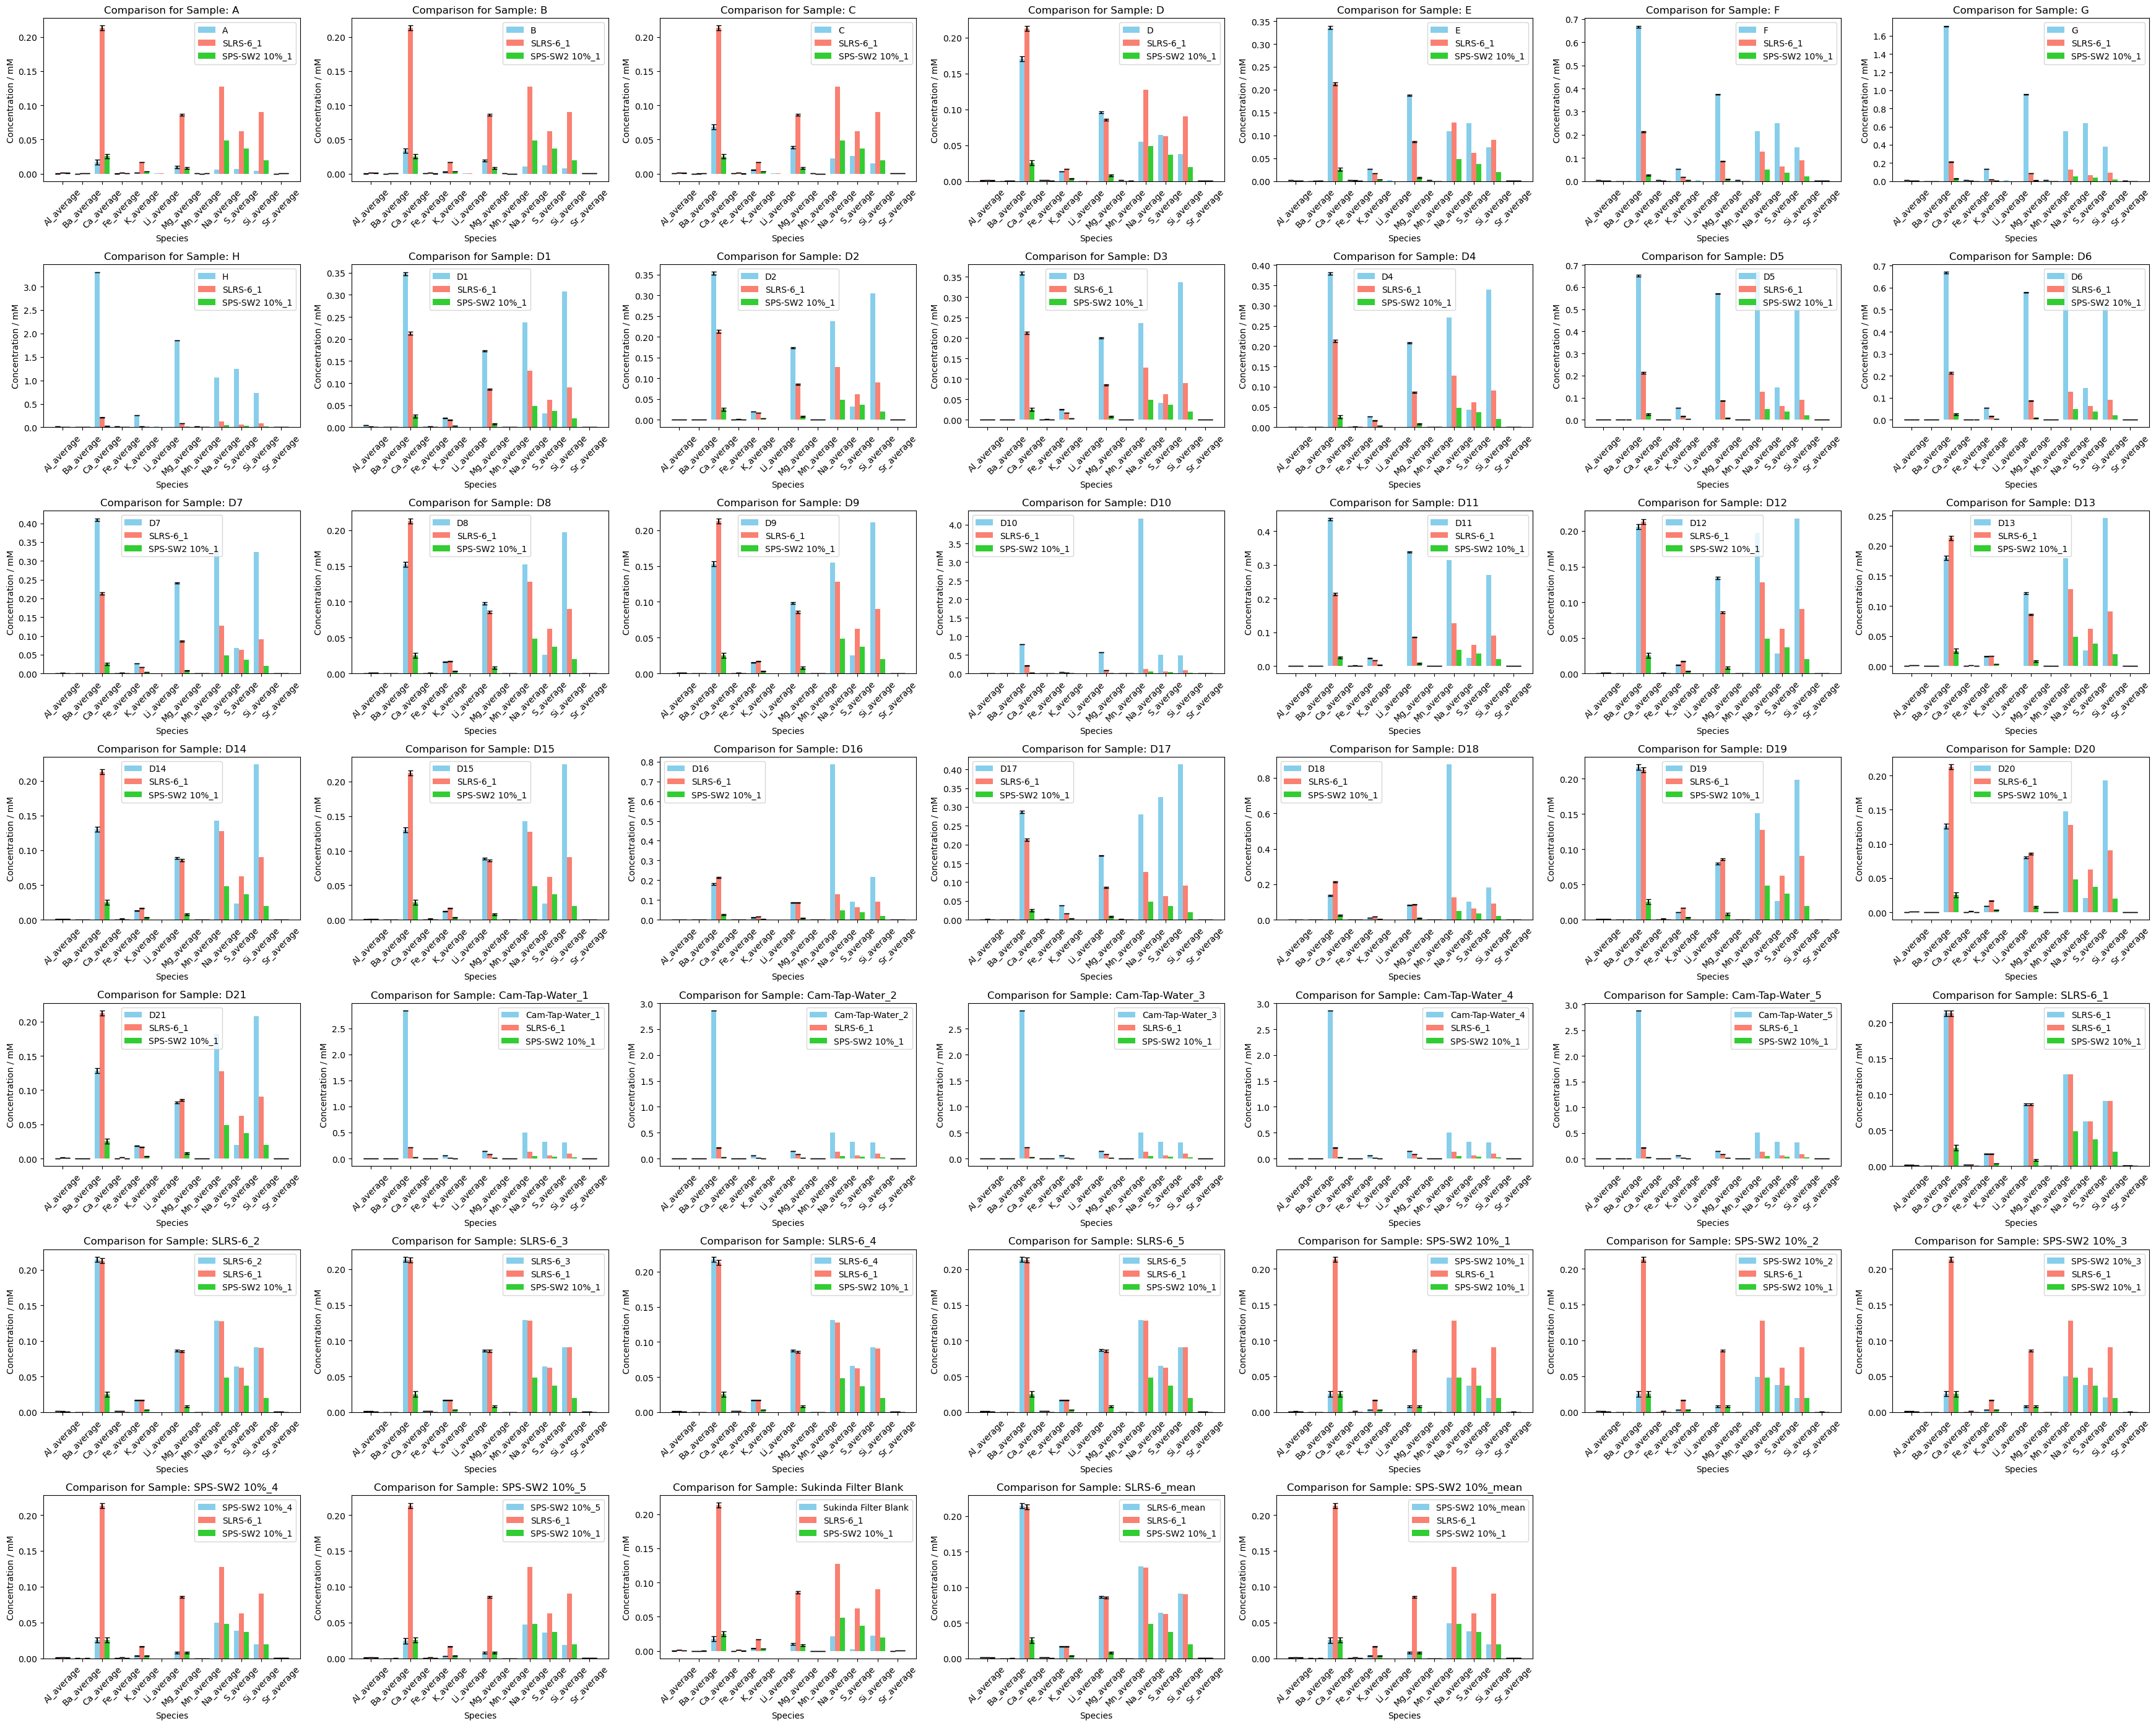

In [2]:
fig = bar_by_sample(ds)
plt.show()  # display the figure

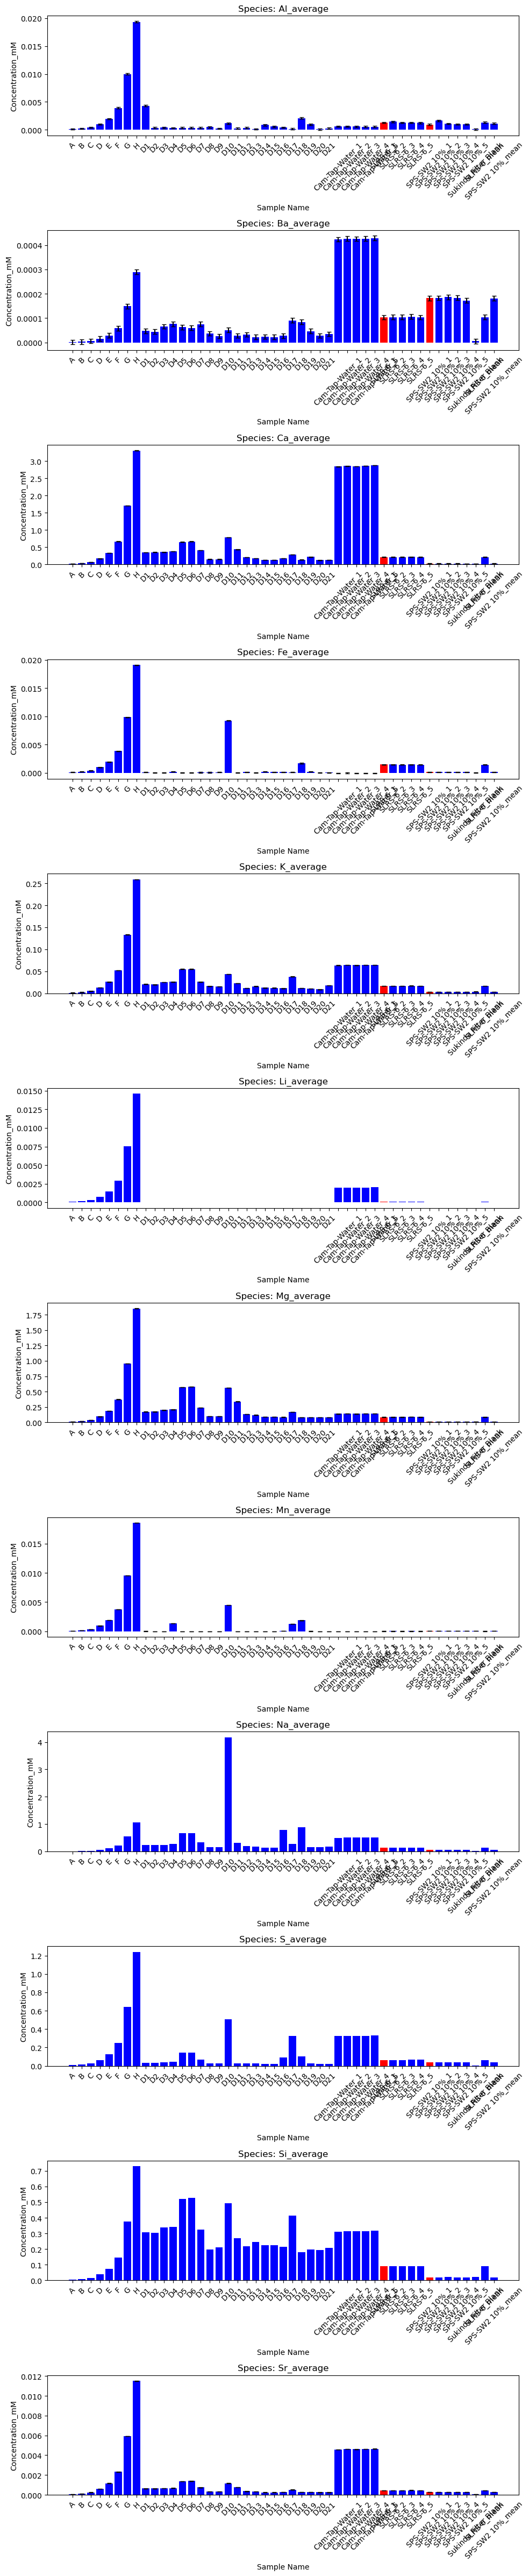

<Figure size 640x480 with 0 Axes>

In [3]:
# Get the figure with bar charts for each species, highlighting 'sampleA' and 'sampleC'
bar_by_species(ds, var_name='Concentration_mM', comp_samples=['SLRS-6_1', 'SPS-SW2 10%_1', 'BW'])

# To display the figure, you can call:
plt.show()

plt.savefig('bar_by_species.png', dpi=300)

In [4]:
from icpoes.analysis import find_dilutions

# Call the function.
results = find_dilutions(ds, 'Concentration_mM')


Sample: D10
Largest species outside calibration: Na_average, Required dilution ratio: 3.91
Other species outside of calibration: []
-----------------------------------
Sample: Cam-Tap-Water_1
Largest species outside calibration: Ba_average, Required dilution ratio: 1.46
Other species outside of calibration: []
-----------------------------------
Sample: Cam-Tap-Water_2
Largest species outside calibration: Ba_average, Required dilution ratio: 1.47
Other species outside of calibration: []
-----------------------------------
Sample: Cam-Tap-Water_3
Largest species outside calibration: Ba_average, Required dilution ratio: 1.47
Other species outside of calibration: []
-----------------------------------
Sample: Cam-Tap-Water_4
Largest species outside calibration: Ba_average, Required dilution ratio: 1.47
Other species outside of calibration: []
-----------------------------------
Sample: Cam-Tap-Water_5
Largest species outside calibration: Ba_average, Required dilution ratio: 1.48
Other spe

Means for Ca_average
Diluted samples mean: 0.3512017444444444
Undiluted samples mean: 4.987513857142858
Max conc. at proposed dilution: 0.8830406666666666
----------
Means for K_average
Diluted samples mean: 0.067348
Undiluted samples mean: 0.9884445652173912
Max conc. at proposed dilution: 0.067348
----------
Means for Mg_average
Diluted samples mean: 0.14650195555555554
Undiluted samples mean: 2.6297684126984127
Max conc. at proposed dilution: 0.2998613333333333
----------
Means for Na_average
Diluted samples mean: 0.14440978851439912
Undiluted samples mean: 3.193311351996326
Max conc. at proposed dilution: 0.6395304787629343
----------


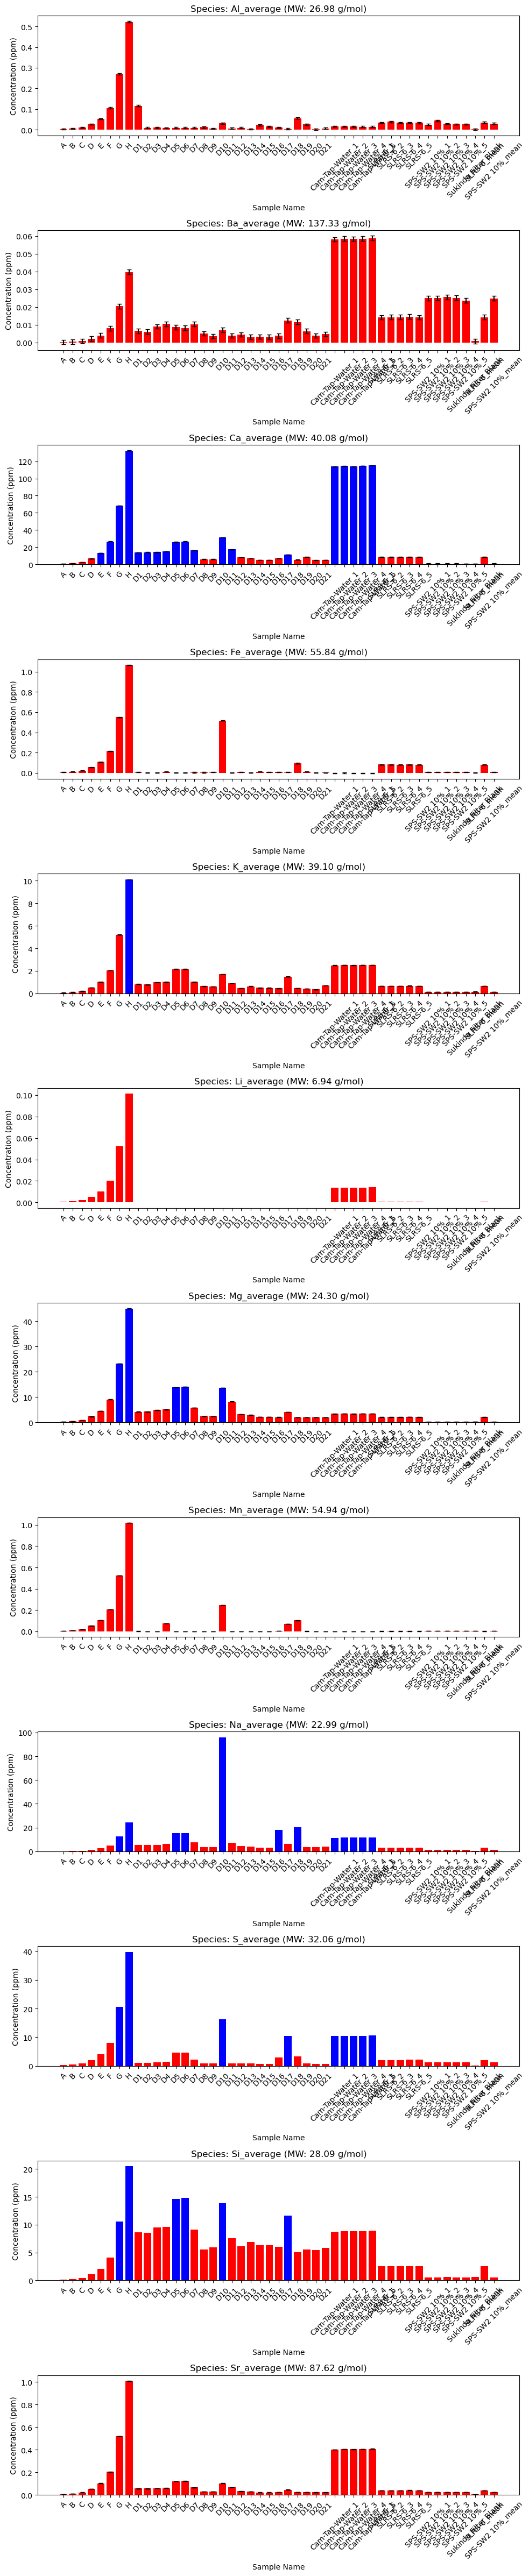

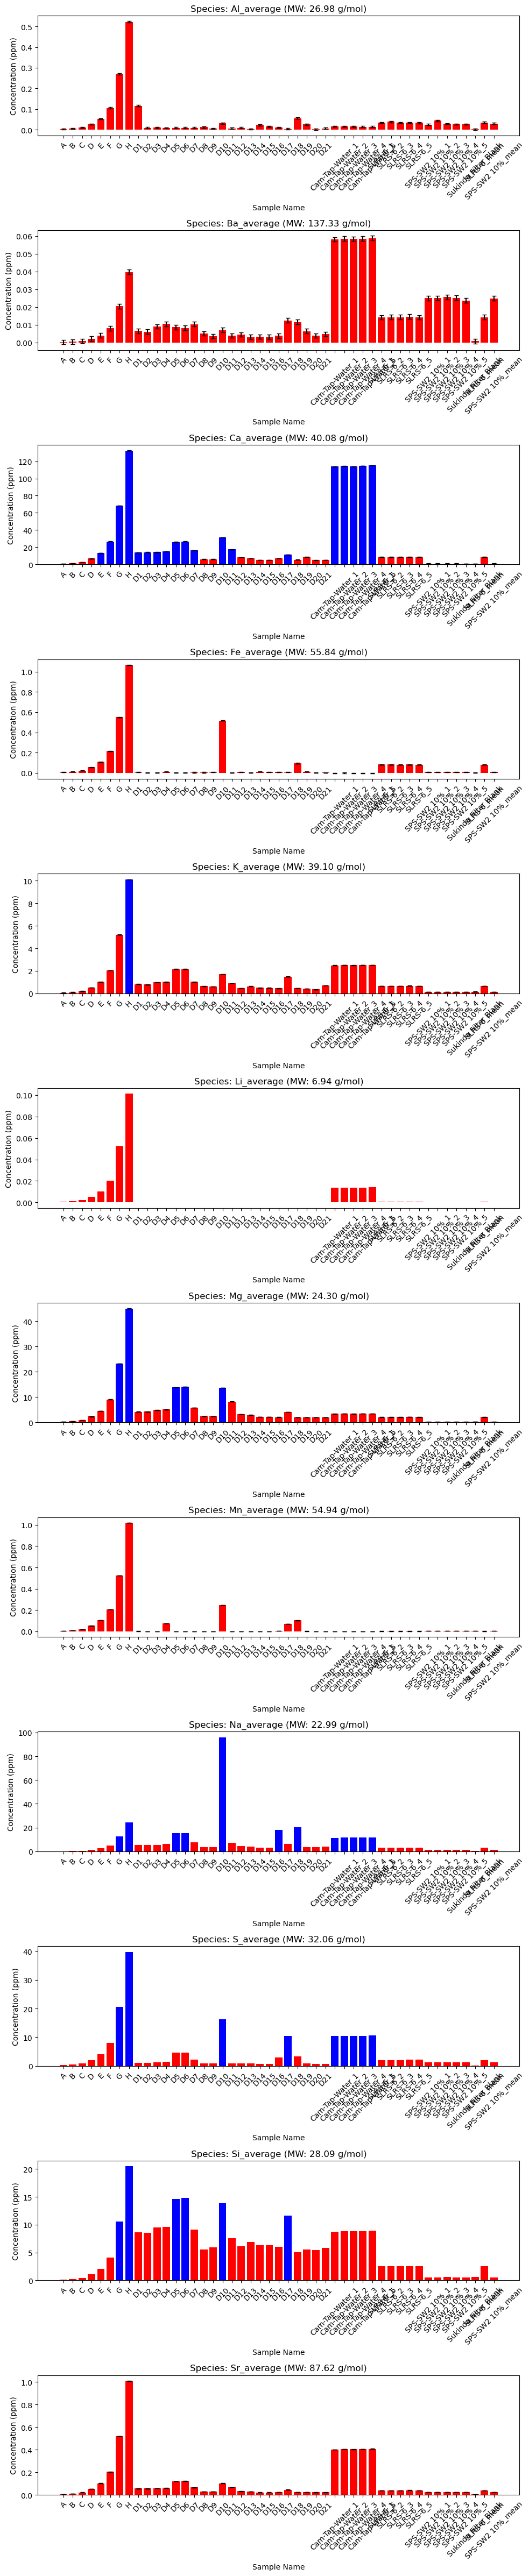

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Assumes this dictionary is defined (as in your original code)
ELEMENTAL_MOLAR_MASSES = {
    "H": 1.00784,
    "He": 4.002602,
    "Li": 6.94,
    "Be": 9.012182,
    "B": 10.81,
    "C": 12.0107,
    "N": 14.0067,
    "O": 15.999,
    "F": 18.998403163,
    "Ne": 20.1797,
    "Na": 22.98976928,
    "Mg": 24.305,
    "Al": 26.9815385,
    "Si": 28.085,
    "P": 30.973761998,
    "S": 32.06,
    "Cl": 35.45,
    "Ar": 39.948,
    "K": 39.0983,
    "Ca": 40.078,
    "Mn": 54.938,    # Manganese
    "Fe": 55.845,    # Iron
    "Sr": 87.62,     # Strontium
    "Ba": 137.327,   # Barium
    # Add more elements as needed
}


def compute_concentration_ppm(ds, mM_var="Concentration_mM", error_var="error",
                              new_var="Concentration_ppm", new_error_var="error_ppm"):
    """
    Compute the concentration in ppm for each species in each sample and assign
    the results to new variables in the dataset.

    For each species the conversion is:
    
        ppm = mM × MW

    where MW is obtained by looking up the first part of the species name in 
    ELEMENTAL_MOLAR_MASSES (defaulting to 1.0 g/mol if not found).

    Additionally, the error in mM is converted to error in ppm by the same factor.

    Parameters
    ----------
    ds : xarray.Dataset
        The dataset containing the mM concentrations and error.
    mM_var : str, optional
        Name of the concentration variable in mM (default "Concentration_mM").
    error_var : str, optional
        Name of the error variable (default "error").
    new_var : str, optional
        Name for the new concentration variable in ppm (default "Concentration_ppm").
    new_error_var : str, optional
        Name for the new error variable in ppm (default "error_ppm").

    Returns
    -------
    ds : xarray.Dataset
        The dataset with added variables for ppm concentrations and ppm errors.
    """
    species_list = ds.coords['species'].values
    conc_mM = ds[mM_var].values      # shape: (n_species, n_samples)
    error_mM = ds[error_var].values    # shape: (n_species,)

    n_species, n_samples = conc_mM.shape
    conc_ppm = np.zeros_like(conc_mM)
    error_ppm = np.zeros_like(error_mM)

    for i, species in enumerate(species_list):
        # Determine the conversion factor from the species name.
        element = species.split('_')[0]
        factor = ELEMENTAL_MOLAR_MASSES.get(element, 1.0)
        conc_ppm[i, :] = conc_mM[i, :] * factor
        error_ppm[i] = error_mM[i] * factor

    ds[new_var] = (("species", "sample_name"), conc_ppm)
    ds[new_error_var] = (("species",), error_ppm)
    return ds


def bar_by_species_ppm_new(ds, ppm_var="Concentration_ppm", error_ppm_var="error_ppm",
                           comp_samples=None):
    """
    Plot bar charts for each species using the computed ppm concentrations.

    This function expects the dataset to already have the new variables for 
    concentrations in ppm and corresponding error (e.g., "Concentration_ppm" 
    and "error_ppm").

    Parameters
    ----------
    ds : xarray.Dataset
        The dataset with the computed ppm data.
    ppm_var : str, optional
        Name of the ppm concentration variable (default "Concentration_ppm").
    error_ppm_var : str, optional
        Name of the ppm error variable (default "error_ppm").
    comp_samples : list of str, optional
        A list of sample names to highlight (drawn in red); if not provided,
        a simple threshold is used (red for values < 10, blue otherwise).

    Returns
    -------
    fig : matplotlib.figure.Figure
        The figure object containing the subplots.
    """
    if comp_samples is None:
        comp_samples = []

    species_list = ds.coords['species'].values
    n_species = len(species_list)
    fig, axes = plt.subplots(n_species, 1, figsize=(10, 4 * n_species), squeeze=False)

    for i, species in enumerate(species_list):
        ax = axes[i, 0]

        data = ds[ppm_var].sel(species=species)
        error_data = ds[error_ppm_var].sel(species=species).values
        sample_names = ds.coords['sample_name'].values
        values_ppm = data.values

        dilution_factor = 150

        # Set bar colors: red for highlighted samples, blue for others.
        colors = ['red' if value < 10 else 'blue' for value in values_ppm]
        if species in ['Ca_average', 'K_average', 'Mg_average', 'Na_average']:
            undilute_sum = 0
            dilute_sum = 0
            undilute = 0
            dilute = 0
            for value in values_ppm:
                if value < 10:
                    undilute_sum += value
                    undilute += 1
                elif value > 10:
                    dilute_sum += value / dilution_factor
                    dilute += 1
            print(f'Means for {species}')
            print(f'Diluted samples mean: {dilute_sum / dilute}')
            print(f'Undiluted samples mean: {undilute_sum / undilute}')
            print(f'Max conc. at proposed dilution: {values_ppm.max() / dilution_factor}')
            print('----------')

        ax.bar(sample_names, values_ppm, color=colors, yerr=error_data, capsize=3)
        # For the title, display the conversion factor (molecular weight) used.
        element = species.split('_')[0]
        factor = ELEMENTAL_MOLAR_MASSES.get(element, 1.0)
        ax.set_title(f"Species: {species} (MW: {factor:.2f} g/mol)")
        ax.set_xlabel("Sample Name")
        ax.set_ylabel("Concentration (ppm)")
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    return fig

ds = compute_concentration_ppm(ds)
bar_by_species_ppm_new(ds)

In [6]:
ds

<xarray.Dataset> Size: 13kB
Dimensions:            (sample_name: 47, species: 12)
Coordinates:
  * sample_name        (sample_name) <U20 4kB 'A' 'B' ... 'SPS-SW2 10%_mean'
  * species            (species) <U10 480B 'Al_average' ... 'Sr_average'
Data variables:
    Concentration_mM   (species, sample_name) float64 5kB 0.0001001 ... 0.000...
    error              (species) float64 96B 0.0001263 9.667e-06 ... 1.372e-05
    Concentration_ppm  (species, sample_name) float64 5kB 0.0027 ... 0.02448
    error_ppm          (species) float64 96B 0.003407 0.001328 ... nan 0.001202

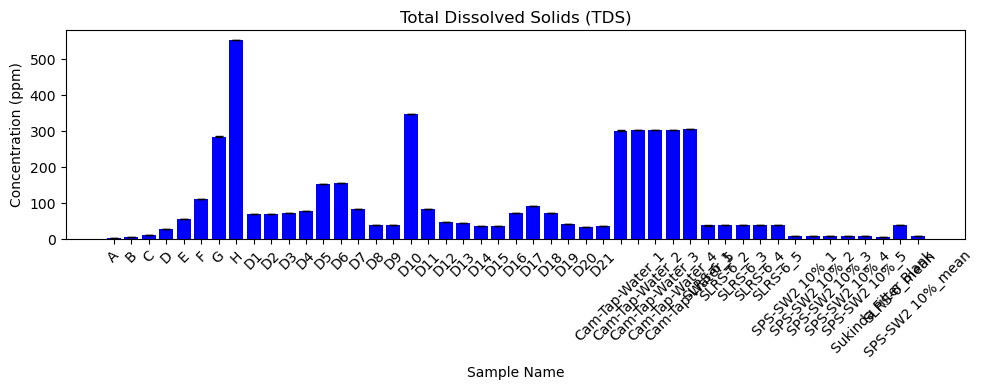

In [7]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

def calculate_tds_da(ds, ppm_var="Concentration_ppm", error_var="error_ppm", tds_label="TDS"):
    """
    Compute total dissolved solids (TDS) as the sum over all species (in ppm)
    for each sample and propagate the error (assuming independent errors,
    so that TDS_error = sqrt(sum(error^2))).
    
    This function returns a new Dataset with a single species (TDS) for both the
    concentration and its error.
    
    Parameters
    ----------
    ds : xarray.Dataset
        The dataset containing the ppm concentration variable and its error.
    ppm_var : str, optional
        Name of the ppm concentration variable (default "Concentration_ppm").
    error_var : str, optional
        Name of the error variable in ppm (default "error_ppm").
    tds_label : str, optional
        The label to use for the TDS row (default "TDS").
        
    Returns
    -------
    tds_ds : xarray.Dataset
        A new Dataset with two variables (ppm concentration and error) that contain
        only the TDS row in their 'species' dimension.
    """
    # Sum the concentrations over the species dimension for each sample.
    # Multiply by two as dataset only contains cations under the assumption of charge balance.
    tds = ds[ppm_var].sum(dim="species") * 2
    # Propagate errors: for independent errors, the error in the sum is
    # sqrt(sum(error^2)).
    tds_error = np.sqrt((ds[error_var]**2).sum(dim="species"))
    
    # Create new DataArrays with a species dimension of length one (only TDS).
    tds_da = tds.expand_dims("species").assign_coords(species=[tds_label])
    tds_error_da = tds_error.expand_dims("species").assign_coords(species=[tds_label])
    
    # Return a Dataset containing only the TDS data.
    tds_ds = xr.Dataset({ppm_var: tds_da, error_var: tds_error_da})
    return tds_ds


def bar_by_tds_ppm(ds, ppm_var="Concentration_ppm", error_var="error_ppm", comp_samples=None):
    """
    Plot a bar chart for TDS (with error bars) computed for each sample.
    
    This function calculates TDS (and propagates its error) using calculate_tds_da,
    and then plots the resulting TDS data. Only the TDS row is used.
    
    Parameters
    ----------
    ds : xarray.Dataset
        The dataset containing the ppm concentration variable and error.
    ppm_var : str, optional
        Name of the ppm concentration variable (default "Concentration_ppm").
    error_var : str, optional
        Name of the error variable in ppm (default "error_ppm").
    comp_samples : list of str, optional
        A list of sample names to highlight (if provided); samples in this list
        will be drawn in red.
    
    Returns
    -------
    fig : matplotlib.figure.Figure
        The figure object with the TDS bar plot.
    """
    # Calculate the TDS dataset containing only the TDS row.
    tds_ds = calculate_tds_da(ds, ppm_var=ppm_var, error_var=error_var)
    
    # Extract the TDS DataArrays for concentration and error.
    tds_da = tds_ds[ppm_var].sel(species="TDS")
    tds_error_da = tds_ds[error_var].sel(species="TDS")
    
    sample_names = ds.coords["sample_name"].values
    values_ppm = tds_da.values
    error_ppm = tds_error_da.values

    # Define bar colors.
    if comp_samples:
        colors = ['red' if sample in comp_samples else 'blue' for sample in sample_names]
    else:
        colors = ['blue'] * len(sample_names)
    
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(sample_names, values_ppm, yerr=error_ppm, capsize=3, color=colors)
    ax.set_title("Total Dissolved Solids (TDS)")
    ax.set_xlabel("Sample Name")
    ax.set_ylabel("Concentration (ppm)")
    ax.tick_params(axis="x", rotation=45)
    plt.tight_layout()
    return fig

# Example usage:
# Assuming ds already has 'Concentration_ppm' and 'error_ppm' variables,
# you can compute TDS and then plot:
tds_ds = calculate_tds_da(ds)
fig = bar_by_tds_ppm(ds)
plt.show()


da

In [8]:

df = tds_ds['Concentration_ppm'].to_dataframe()
df.describe()

,Concentration_ppm
count,47.000000
mean,97.112717
std,120.365262
min,2.859516
25%,35.087501
50%,41.986799
75%,88.067975
max,552.126907


In [9]:
import xarray as xr

def calculate_dilutions(ds, tds_var="Concentration_ppm", species_label="TDS", 
                        target_tds=5, final_volume=10):
    """
    Calculate the dilution factor and the volumes of sample and MQ water required 
    to prepare a diluted sample with a target TDS of 5 ppm in a final volume of 10 mL.
    
    The calculation is based on the mass balance equation:
    
        C₁ * V_sample = C_target * V_final
    
    where:
        - C₁ is the original TDS (in ppm) of the sample,
        - V_sample is the volume of the original sample required,
        - C_target is the target TDS (5 ppm), and
        - V_final is the final volume (10 mL).
    
    The dilution factor is given by:
    
        DF = C₁ / C_target
    
    Parameters
    ----------
    ds : xarray.Dataset
        The dataset that contains the TDS data for each sample. It is assumed that 
        the TDS is stored in the variable `tds_var` and the TDS row is labeled using 
        the `species_label` coordinate.
    tds_var : str, optional
        The name of the variable containing TDS data (default "Concentration_ppm").
    species_label : str, optional
        The label for the TDS row in the species coordinate (default "TDS").
    target_tds : float, optional
        The target TDS (in ppm) for the diluted sample (default 5 ppm).
    final_volume : float, optional
        The final volume of the diluted sample in mL (default 10 mL).
    
    Returns
    -------
    dilution_ds : xarray.Dataset
        A Dataset with the following variables (indexed by sample_name):
            - dilution_factor : the factor by which the original sample must be diluted.
            - sample_volume   : the volume (in mL) of the original sample required.
            - water_volume    : the volume (in mL) of MQ water required.
    """
    # Extract the TDS values for each sample from the TDS row.
    tds = ds[tds_var].sel(species=species_label)
    
    # Calculate the dilution factor for each sample.
    dilution_factor = tds / target_tds
    
    # Using the mass balance equation, compute the sample volume needed:
    # V_sample = (target_tds * final_volume) / C_initial
    sample_volume = (target_tds * final_volume) / tds
    
    # The volume of MQ water required is the remainder.
    water_volume = final_volume - sample_volume
    
    # Package the results into a new Dataset.
    dilution_ds = xr.Dataset({
        "dilution_factor": dilution_factor,
        "sample_volume": sample_volume,
        "water_volume": water_volume
    })
    
    return dilution_ds


dilution_ds = calculate_dilutions(tds_ds)

In [10]:
import numpy as np

# Helper function to truncate to a given precision.
def truncate_to_precision(x, precision):
    # Multiply by the reciprocal of precision, take floor, then multiply back.
    return np.floor(x / precision) * precision

# Convert the xarray.Dataset to a pandas DataFrame.
dilution_df = dilution_ds.to_dataframe().reset_index()

# Convert volumes from mL to µL.
dilution_df["sample_volume_µL"] = dilution_df["sample_volume"] * 1000
dilution_df["water_volume_µL"] = dilution_df["water_volume"] * 1000

# Truncate to 1 µL precision.
dilution_df["sample_volume_µL"] = truncate_to_precision(dilution_df["sample_volume_µL"], 1.0)
dilution_df["water_volume_µL"] = truncate_to_precision(dilution_df["water_volume_µL"], 1.0)

# Format the values as strings with no decimals.
dilution_df["sample_volume_µL"] = dilution_df["sample_volume_µL"].map(lambda x: f"{x:.0f}")
dilution_df["water_volume_µL"] = dilution_df["water_volume_µL"].map(lambda x: f"{x:.0f}")

# Optionally drop the original mL columns.
dilution_df = dilution_df.drop(columns=["sample_volume", "water_volume"])

# Export the DataFrame to CSV.
dilution_df.to_csv("dilutions.csv", index=False)

